# Notebook Imports

In [1]:
!pip install prince

  Obtaining dependency information for prince from https://files.pythonhosted.org/packages/ea/47/05a78e27a6c7f85b5e006169e4ddf27637867124ef841176f5e4f5ce7f88/prince-0.13.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 415.6/415.6 kB 9.1 MB/s eta 0:00:00


In [2]:
import os
import re
import pandas as pd
import numpy as np
from datetime import date
import seaborn as sns
from scipy import stats
from umap import UMAP

import matplotlib.pyplot as plt
import warnings
from prince import MCA, CA
from sklearn.impute import SimpleImputer
import calendar
from yellowbrick.cluster import SilhouetteVisualizer

from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.manifold import TSNE

warnings.filterwarnings('ignore')

# Constants

In [3]:
FILE = '/kaggle/input/data-science-for-good/Dept_11-00091/11-00091_Field-Interviews_2011-2015.csv'

# Step 1: Data Exploration and Preprocessing

### Load data

In [4]:
data = pd.read_csv(FILE)
df_full = pd.DataFrame(data)

df = df_full.sample(frac=0.1)
df.head()

,INCIDENT_UNIQUE_IDENTIFIER,INCIDENT_UNIQUE_IDENTIFIER.1,SUBJECT_GENDER,LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION,LOCATION_DISTRICT,LOCATION_DISTRICT.1,INCIDENT_DATE,INCIDENT_TIME,SUBJECT_DETAILS,SUBJECT_RACE,...,VEHICLE_DETAILS.1,OFFICER_SUPERVISOR,OFFICER_ID,OFFICER_ASSIGNMENT,OFFICER_ASSIGNMENT.1,OFFICER_ETHNICITY,OFFICER_RACE,OFFICER_AGE,LOCATION_STREET_NUMBER,LOCATION_CITY
81598,904038,587478,MALE,0 DUDLEY ST,B2,3,12/18/12 0:00,12/18/12 0:00,YES,W(White),...,NO DATA ENTERED,11610.0,89907,3,B2,NaN,W(White),34,1389,Roxbury
101267,880108,563862,MALE,COLUMBIA ST at WASHINGTON ST,B3,4,5/23/12 0:00,5/23/12 0:00,YES,B(Black),...,MA,11756.0,103761,4,B3,NaN,B(Black),20,1021,NO DATA ENTERED
95644,965761,648275,MALE,49 WALFORD WY,A15,12,10/6/14 0:00,10/6/14 0:00,NO,B(Black),...,NO DATA ENTERED,11612.0,108892,16,YVSF,NaN,B(Black),17,4731,NO DATA ENTERED
23901,701406,516188,MALE,40H ANNUNCIATION RD,B2,3,3/3/11 0:00,3/3/11 0:00,NaN,H(Hispanic),...,NO DATA ENTERED,10534.0,11120,16,YVSF,NaN,H(Hispanic),19,163,NO DATA ENTERED
98059,969512,651780,MALE,39 LINSKY BARRY CT,C6,6,11/4/14 0:00,11/4/14 0:00,YES,B(Black),...,NO DATA ENTERED,86124.0,103611,16,YVSF,NaN,B(Black),19,2695,NO DATA ENTERED


In [5]:
print(f"\nThe shape of the data: {df.shape}\n")
print(f"The types of the data: \n{df.dtypes}\n")
print(f"The empty row in the data: \n{df.isnull().sum()}")


The shape of the data: (15223, 34)

The types of the data: 
INCIDENT_UNIQUE_IDENTIFIER                      object
INCIDENT_UNIQUE_IDENTIFIER.1                    object
SUBJECT_GENDER                                  object
LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION    object
LOCATION_DISTRICT                               object
LOCATION_DISTRICT.1                             object
INCIDENT_DATE                                   object
INCIDENT_TIME                                   object
SUBJECT_DETAILS                                 object
SUBJECT_RACE                                    object
SUBJECT_DETAILS.1                               object
SUBJECT_DETAILS.2                               object
UNKNOWN_FIELD_TYPE                              object
UNKNOWN_FIELD_TYPE.1                            object
SEARCH_CONDUCTED                                object
SEARCH_REASON                                   object
INCIDENT_REASON                                 object
INCI

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15223 entries, 81598 to 33854
Data columns (total 34 columns):
 #   Column                                        Non-Null Count  Dtype 
---  ------                                        --------------  ----- 
 0   INCIDENT_UNIQUE_IDENTIFIER                    15223 non-null  object
 1   INCIDENT_UNIQUE_IDENTIFIER.1                  15223 non-null  object
 2   SUBJECT_GENDER                                15223 non-null  object
 3   LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION  15223 non-null  object
 4   LOCATION_DISTRICT                             15223 non-null  object
 5   LOCATION_DISTRICT.1                           15223 non-null  object
 6   INCIDENT_DATE                                 15223 non-null  object
 7   INCIDENT_TIME                                 15223 non-null  object
 8   SUBJECT_DETAILS                               13174 non-null  object
 9   SUBJECT_RACE                                  15223 non-null  object
 10 

### Data Cleaning

In [7]:
# converting 'NO DATA ENTERED', 'UNKNOWN' values in columns to NaN values
for feature in df.columns:
    df[feature].replace(to_replace=["NO DATA ENTERED", 'UNKNOWN', '0', 0, 'FIO_DATE', 'OTHER', 'OTHERS'
                                   'AGE_AT_FIO_CORRECTED', 'DISCRIPTION', 'AGE_AT_FIO_CORRECTED'], value=np.nan, inplace=True)

In [8]:
print(f"The empty row in the data: \n{df.isnull().sum()}")

The empty row in the data: 
INCIDENT_UNIQUE_IDENTIFIER                          0
INCIDENT_UNIQUE_IDENTIFIER.1                        0
SUBJECT_GENDER                                     16
LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION        0
LOCATION_DISTRICT                                   4
LOCATION_DISTRICT.1                                 0
INCIDENT_DATE                                       0
INCIDENT_TIME                                       0
SUBJECT_DETAILS                                  2195
SUBJECT_RACE                                      691
SUBJECT_DETAILS.1                                1326
SUBJECT_DETAILS.2                                2532
UNKNOWN_FIELD_TYPE                                  0
UNKNOWN_FIELD_TYPE.1                                0
SEARCH_CONDUCTED                                13125
SEARCH_REASON                                   11595
INCIDENT_REASON                                  4668
INCIDENT_REASON.1                                   0


In [9]:
# dropping columns where the NaN values were more than 4000
for feature in df.columns:
    if df[feature].isnull().sum() > 4000:
        df.drop([feature], axis=1, inplace=True)

In [10]:
df.head()

,INCIDENT_UNIQUE_IDENTIFIER,INCIDENT_UNIQUE_IDENTIFIER.1,SUBJECT_GENDER,LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION,LOCATION_DISTRICT,LOCATION_DISTRICT.1,INCIDENT_DATE,INCIDENT_TIME,SUBJECT_DETAILS,SUBJECT_RACE,...,UNKNOWN_FIELD_TYPE.1,INCIDENT_REASON.1,DISPOSITION,OFFICER_SUPERVISOR,OFFICER_ID,OFFICER_ASSIGNMENT,OFFICER_ASSIGNMENT.1,OFFICER_RACE,OFFICER_AGE,LOCATION_STREET_NUMBER
81598,904038,587478,MALE,0 DUDLEY ST,B2,3,12/18/12 0:00,12/18/12 0:00,YES,W(White),...,NO,"DRUGS, CONSPIRACY",F,11610.0,89907,3,B2,W(White),34,1389
101267,880108,563862,MALE,COLUMBIA ST at WASHINGTON ST,B3,4,5/23/12 0:00,5/23/12 0:00,YES,B(Black),...,NO,"INVESTIGATE, PERSON",S,11756.0,103761,4,B3,B(Black),20,1021
95644,965761,648275,MALE,49 WALFORD WY,A15,12,10/6/14 0:00,10/6/14 0:00,NO,B(Black),...,NO,"INVESTIGATE, PERSON",F,11612.0,108892,16,YVSF,B(Black),17,4731
23901,701406,516188,MALE,40H ANNUNCIATION RD,B2,3,3/3/11 0:00,3/3/11 0:00,NaN,H(Hispanic),...,NO,"INVESTIGATE, PERSON",F,10534.0,11120,16,YVSF,H(Hispanic),19,163
98059,969512,651780,MALE,39 LINSKY BARRY CT,C6,6,11/4/14 0:00,11/4/14 0:00,YES,B(Black),...,NO,"DRUGS, INVESTIGATION",F,86124.0,103611,16,YVSF,B(Black),19,2695


In [11]:
# Number of unique values in the dataset columns
for feature in df.columns:
    print(f'Number of unique values in {feature} column:', len(df[feature].unique()))

Number of unique values in INCIDENT_UNIQUE_IDENTIFIER column: 15223
Number of unique values in INCIDENT_UNIQUE_IDENTIFIER.1 column: 15223
Number of unique values in SUBJECT_GENDER column: 3
Number of unique values in LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION column: 9144
Number of unique values in LOCATION_DISTRICT column: 19
Number of unique values in LOCATION_DISTRICT.1 column: 33
Number of unique values in INCIDENT_DATE column: 1745
Number of unique values in INCIDENT_TIME column: 1745
Number of unique values in SUBJECT_DETAILS column: 3
Number of unique values in SUBJECT_RACE column: 7
Number of unique values in SUBJECT_DETAILS.1 column: 12089
Number of unique values in SUBJECT_DETAILS.2 column: 9
Number of unique values in UNKNOWN_FIELD_TYPE column: 19
Number of unique values in UNKNOWN_FIELD_TYPE.1 column: 2
Number of unique values in INCIDENT_REASON.1 column: 130
Number of unique values in DISPOSITION column: 8
Number of unique values in OFFICER_SUPERVISOR column: 211
Number 

In [12]:
print(f"The empty row in the data: \n{df.isnull().sum()}")

The empty row in the data: 
INCIDENT_UNIQUE_IDENTIFIER                         0
INCIDENT_UNIQUE_IDENTIFIER.1                       0
SUBJECT_GENDER                                    16
LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION       0
LOCATION_DISTRICT                                  4
LOCATION_DISTRICT.1                                0
INCIDENT_DATE                                      0
INCIDENT_TIME                                      0
SUBJECT_DETAILS                                 2195
SUBJECT_RACE                                     691
SUBJECT_DETAILS.1                               1326
SUBJECT_DETAILS.2                               2532
UNKNOWN_FIELD_TYPE                                 0
UNKNOWN_FIELD_TYPE.1                               0
INCIDENT_REASON.1                                  0
DISPOSITION                                      872
OFFICER_SUPERVISOR                              1601
OFFICER_ID                                         0
OFFICER_ASSIGNMENT

In [13]:
df.shape

(15223, 23)

In [14]:
df.drop(['INCIDENT_UNIQUE_IDENTIFIER', 'INCIDENT_UNIQUE_IDENTIFIER.1', 'OFFICER_ID', 'INCIDENT_TIME', 'OFFICER_SUPERVISOR', 
         'OFFICER_ASSIGNMENT', 'LOCATION_STREET_NUMBER', 'SUBJECT_DETAILS.1', 'OFFICER_RACE',
         'LOCATION_DISTRICT.1', 'UNKNOWN_FIELD_TYPE.1', 'UNKNOWN_FIELD_TYPE', 'DISPOSITION'], axis=1, inplace=True)

In [15]:
df.shape

(15223, 10)

In [16]:
df.head()

,SUBJECT_GENDER,LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION,LOCATION_DISTRICT,INCIDENT_DATE,SUBJECT_DETAILS,SUBJECT_RACE,SUBJECT_DETAILS.2,INCIDENT_REASON.1,OFFICER_ASSIGNMENT.1,OFFICER_AGE
81598,MALE,0 DUDLEY ST,B2,12/18/12 0:00,YES,W(White),NaN,"DRUGS, CONSPIRACY",B2,34
101267,MALE,COLUMBIA ST at WASHINGTON ST,B3,5/23/12 0:00,YES,B(Black),Med,"INVESTIGATE, PERSON",B3,20
95644,MALE,49 WALFORD WY,A15,10/6/14 0:00,NO,B(Black),Dark,"INVESTIGATE, PERSON",YVSF,17
23901,MALE,40H ANNUNCIATION RD,B2,3/3/11 0:00,NaN,H(Hispanic),Med,"INVESTIGATE, PERSON",YVSF,19
98059,MALE,39 LINSKY BARRY CT,C6,11/4/14 0:00,YES,B(Black),Med,"DRUGS, INVESTIGATION",YVSF,19


In [17]:
df.duplicated().value_counts()

False    15158
True        65
Name: count, dtype: int64

In [18]:
df.drop_duplicates(inplace=True)

In [19]:
print(f"The empty row in the data: \n{df.isnull().sum()}")

The empty row in the data: 
SUBJECT_GENDER                                    16
LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION       0
LOCATION_DISTRICT                                  4
INCIDENT_DATE                                      0
SUBJECT_DETAILS                                 2186
SUBJECT_RACE                                     689
SUBJECT_DETAILS.2                               2524
INCIDENT_REASON.1                                  0
OFFICER_ASSIGNMENT.1                              50
OFFICER_AGE                                       24
dtype: int64


In [20]:
# Handling missing values

mode_imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
mode_imputer.fit(df)
imputed_data = mode_imputer.transform(df)
df = pd.DataFrame(data=imputed_data, columns=df.columns)
df.isnull().sum()

SUBJECT_GENDER                                  0
LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION    0
LOCATION_DISTRICT                               0
INCIDENT_DATE                                   0
SUBJECT_DETAILS                                 0
SUBJECT_RACE                                    0
SUBJECT_DETAILS.2                               0
INCIDENT_REASON.1                               0
OFFICER_ASSIGNMENT.1                            0
OFFICER_AGE                                     0
dtype: int64

### Data Preprocessing

In [21]:
# Extracting dates

df['INCIDENT_DATE'] = pd.to_datetime(df['INCIDENT_DATE'], format="mixed")
df["INCIDENT_YEAR"] = df["INCIDENT_DATE"].dt.strftime('%Y')
df["INCIDENT_MONTH"] = df["INCIDENT_DATE"].dt.strftime('%B')

df.drop(['INCIDENT_DATE'], axis=1, inplace=True)

In [22]:
df.head()

,SUBJECT_GENDER,LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION,LOCATION_DISTRICT,SUBJECT_DETAILS,SUBJECT_RACE,SUBJECT_DETAILS.2,INCIDENT_REASON.1,OFFICER_ASSIGNMENT.1,OFFICER_AGE,INCIDENT_YEAR,INCIDENT_MONTH
0,MALE,0 DUDLEY ST,B2,YES,W(White),Med,"DRUGS, CONSPIRACY",B2,34,2012,December
1,MALE,COLUMBIA ST at WASHINGTON ST,B3,YES,B(Black),Med,"INVESTIGATE, PERSON",B3,20,2012,May
2,MALE,49 WALFORD WY,A15,NO,B(Black),Dark,"INVESTIGATE, PERSON",YVSF,17,2014,October
3,MALE,40H ANNUNCIATION RD,B2,YES,H(Hispanic),Med,"INVESTIGATE, PERSON",YVSF,19,2011,March
4,MALE,39 LINSKY BARRY CT,C6,YES,B(Black),Med,"DRUGS, INVESTIGATION",YVSF,19,2014,November


In [23]:
# replace weird years
df['INCIDENT_YEAR'] = df['INCIDENT_YEAR'].astype(int)
replace = df[(df['INCIDENT_YEAR'] < 2011) | (df['INCIDENT_YEAR'] > 2015)]['INCIDENT_YEAR'].tolist()
value = round(df[(df['INCIDENT_YEAR'] >= 2011) | (df['INCIDENT_YEAR'] <= 2015)]['INCIDENT_YEAR'].mean())
df['INCIDENT_YEAR'].replace(to_replace=replace, value=value, inplace=True)

In [24]:
df['INCIDENT_YEAR'] = df['INCIDENT_YEAR'].astype(str)
df['INCIDENT_YEAR'].value_counts()

INCIDENT_YEAR
2012    3885
2011    3578
2013    3436
2014    3308
2015     951
Name: count, dtype: int64

In [25]:
list_ = df['INCIDENT_REASON.1'].unique().tolist()

dict_ = {
    'DRUGS': ['DRUGS', 'OVERDOSE'],
    '209A':  ['209A'],
    'ASSAULT': ['ASSAULT', 'A&B'],
    'PROSTITUTION': ['PROSTITUTION'],
    'ALCOHOL': ['PUBLIC DRINKING', 'ALCOHOL'],
    'ABDW': ['ABDW', 'A D/W'],
    'B&E': ['B&E'], 
    'MV': ['MV', 'M/V'], 
    'ROBBERY': ['ROBBERY', 'LARCENY', 'STOLEN'],
    'DISTURBING': ['DISTURBING', 'PEACE', 'LOUD PARTY', 'DISTURBANCE', 'NOISYHOUSE', 'NOISE'],
    'SEXUAL OFFENDER': ['SEXUAL OFFENDER', 'SEX-ASSAULT', 'RAPE', 'SEX', 'SEX-ASSAULT'], 
    'FIREARM': ['FIREARM', 'FIRE'], 
    'HIT & RUN': ['HIT', 'RUN'],
    'SEARCH WARRANT': ['SEARCH WARRANT', 'WARRANTS'],
    'THREATS': ['THREATS', 'THREAT'],
    'CITY ORDINANCES': ['CITY ORDINANCES'],
    'MISSING PERSON': ['MISSING PERSON'],
    'PROPERTY DAMAGE': ['PROPERTY', 'DAMAGE'], 
    'HARASSMENT': ['HARASSMENT']
}

for item in list_:
    for key, values in dict_.items():            
        if any(value in item for value in values):
            df['INCIDENT_REASON.1'].replace(item, value=key, inplace=True)                 
            break 

# Find values with counts less than or equal to 1
infrequent_values = df['INCIDENT_REASON.1'].value_counts()[df['INCIDENT_REASON.1'].value_counts() <= 1].index

# Replace those infrequent values with 'OTHERS'
df['INCIDENT_REASON.1'] = df['INCIDENT_REASON.1'].replace(infrequent_values, 'OTHERS')

In [26]:
len(df['INCIDENT_REASON.1'].value_counts())

44

In [27]:
# replace weird ages 
df['OFFICER_AGE'] = df['OFFICER_AGE'].astype(int)
replace = df[(df['OFFICER_AGE'] < 15) | (df['OFFICER_AGE'] > 75)]['OFFICER_AGE'].tolist()
value = round(df[(df['OFFICER_AGE'] >= 15) | (df['OFFICER_AGE'] <= 75)]['OFFICER_AGE'].mean())
df['OFFICER_AGE'].replace(to_replace=replace, value=value, inplace=True)

# Define a dictionary of age group labels
age_groups = {
    '15-19': range(15, 20),
    '20-29': range(20, 30),
    '30-39': range(30, 40),
    '40-49': range(40, 50),
    '50-59': range(50, 60),
    '60-69': range(60, 70),
    '70+': range(70, 110),  # Assuming 70 and above
}

# Iterate through the age group labels and replace values in the DataFrame
for age_group, age_range in age_groups.items():
    df['OFFICER_AGE'] = df['OFFICER_AGE'].replace(age_range, age_group)

In [28]:
df.head()

,SUBJECT_GENDER,LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION,LOCATION_DISTRICT,SUBJECT_DETAILS,SUBJECT_RACE,SUBJECT_DETAILS.2,INCIDENT_REASON.1,OFFICER_ASSIGNMENT.1,OFFICER_AGE,INCIDENT_YEAR,INCIDENT_MONTH
0,MALE,0 DUDLEY ST,B2,YES,W(White),Med,DRUGS,B2,30-39,2012,December
1,MALE,COLUMBIA ST at WASHINGTON ST,B3,YES,B(Black),Med,"INVESTIGATE, PERSON",B3,20-29,2012,May
2,MALE,49 WALFORD WY,A15,NO,B(Black),Dark,"INVESTIGATE, PERSON",YVSF,15-19,2014,October
3,MALE,40H ANNUNCIATION RD,B2,YES,H(Hispanic),Med,"INVESTIGATE, PERSON",YVSF,15-19,2011,March
4,MALE,39 LINSKY BARRY CT,C6,YES,B(Black),Med,DRUGS,YVSF,15-19,2014,November


In [29]:
addresses = df['LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION'].unique().tolist()

street_name_mapping = {}

# Iterate through the addresses and extract street names
for address in addresses:
    parts = address.split(' at ', 1)  # Split at 'at'
    modified_address = parts[0].strip()

    match = re.search(r'[^0-9]+$', modified_address)
    if match:
        old_street_name = address
        new_street_name = match.group(0).strip()  # Remove leading/trailing spaces
        street_name_mapping[old_street_name] = new_street_name

# Use the .replace() method to replace old street names with new names
df['LOCATION_STREET_ADDRESS'] = df['LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION'].replace(street_name_mapping)

In [30]:
df.drop(['LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION'], axis=1, inplace=True)
df.head()

,SUBJECT_GENDER,LOCATION_DISTRICT,SUBJECT_DETAILS,SUBJECT_RACE,SUBJECT_DETAILS.2,INCIDENT_REASON.1,OFFICER_ASSIGNMENT.1,OFFICER_AGE,INCIDENT_YEAR,INCIDENT_MONTH,LOCATION_STREET_ADDRESS
0,MALE,B2,YES,W(White),Med,DRUGS,B2,30-39,2012,December,DUDLEY ST
1,MALE,B3,YES,B(Black),Med,"INVESTIGATE, PERSON",B3,20-29,2012,May,COLUMBIA ST
2,MALE,A15,NO,B(Black),Dark,"INVESTIGATE, PERSON",YVSF,15-19,2014,October,WALFORD WY
3,MALE,B2,YES,H(Hispanic),Med,"INVESTIGATE, PERSON",YVSF,15-19,2011,March,H ANNUNCIATION RD
4,MALE,C6,YES,B(Black),Med,DRUGS,YVSF,15-19,2014,November,LINSKY BARRY CT


In [31]:
for feature in df.columns:
    print(f'Number of unique values in {feature} column:', len(df[feature].unique()))

Number of unique values in SUBJECT_GENDER column: 2
Number of unique values in LOCATION_DISTRICT column: 18
Number of unique values in SUBJECT_DETAILS column: 2
Number of unique values in SUBJECT_RACE column: 6
Number of unique values in SUBJECT_DETAILS.2 column: 8
Number of unique values in INCIDENT_REASON.1 column: 44
Number of unique values in OFFICER_ASSIGNMENT.1 column: 22
Number of unique values in OFFICER_AGE column: 7
Number of unique values in INCIDENT_YEAR column: 5
Number of unique values in INCIDENT_MONTH column: 12
Number of unique values in LOCATION_STREET_ADDRESS column: 1745


In [32]:
df.duplicated().value_counts()
print(df.duplicated().value_counts())
df.drop_duplicates(inplace=True)

False    14700
True       458
Name: count, dtype: int64


In [33]:
df.shape

(14700, 11)

### Data Encoding

In [34]:
df.dtypes

SUBJECT_GENDER             object
LOCATION_DISTRICT          object
SUBJECT_DETAILS            object
SUBJECT_RACE               object
SUBJECT_DETAILS.2          object
INCIDENT_REASON.1          object
OFFICER_ASSIGNMENT.1       object
OFFICER_AGE                object
INCIDENT_YEAR              object
INCIDENT_MONTH             object
LOCATION_STREET_ADDRESS    object
dtype: object

In [35]:
encoded_df = df.copy()

for feature in encoded_df.columns:
    encoded_df[feature] = encoded_df[feature].astype(str)

label_encoder = LabelEncoder()
for column in encoded_df.columns:
    encoded_df[column] = label_encoder.fit_transform(encoded_df[column])

In [36]:
encoded_df.head()

,SUBJECT_GENDER,LOCATION_DISTRICT,SUBJECT_DETAILS,SUBJECT_RACE,SUBJECT_DETAILS.2,INCIDENT_REASON.1,OFFICER_ASSIGNMENT.1,OFFICER_AGE,INCIDENT_YEAR,INCIDENT_MONTH,LOCATION_STREET_ADDRESS
0,1,4,1,5,5,14,4,2,1,2,478
1,1,5,1,1,5,23,5,1,1,8,359
2,1,1,0,1,2,23,21,0,3,10,1606
3,1,4,1,2,5,23,21,0,0,7,700
4,1,9,1,1,5,14,21,0,3,9,905


# Step 2: Exploratory Data Analysis (EDA)

### Gender and Race Distribution

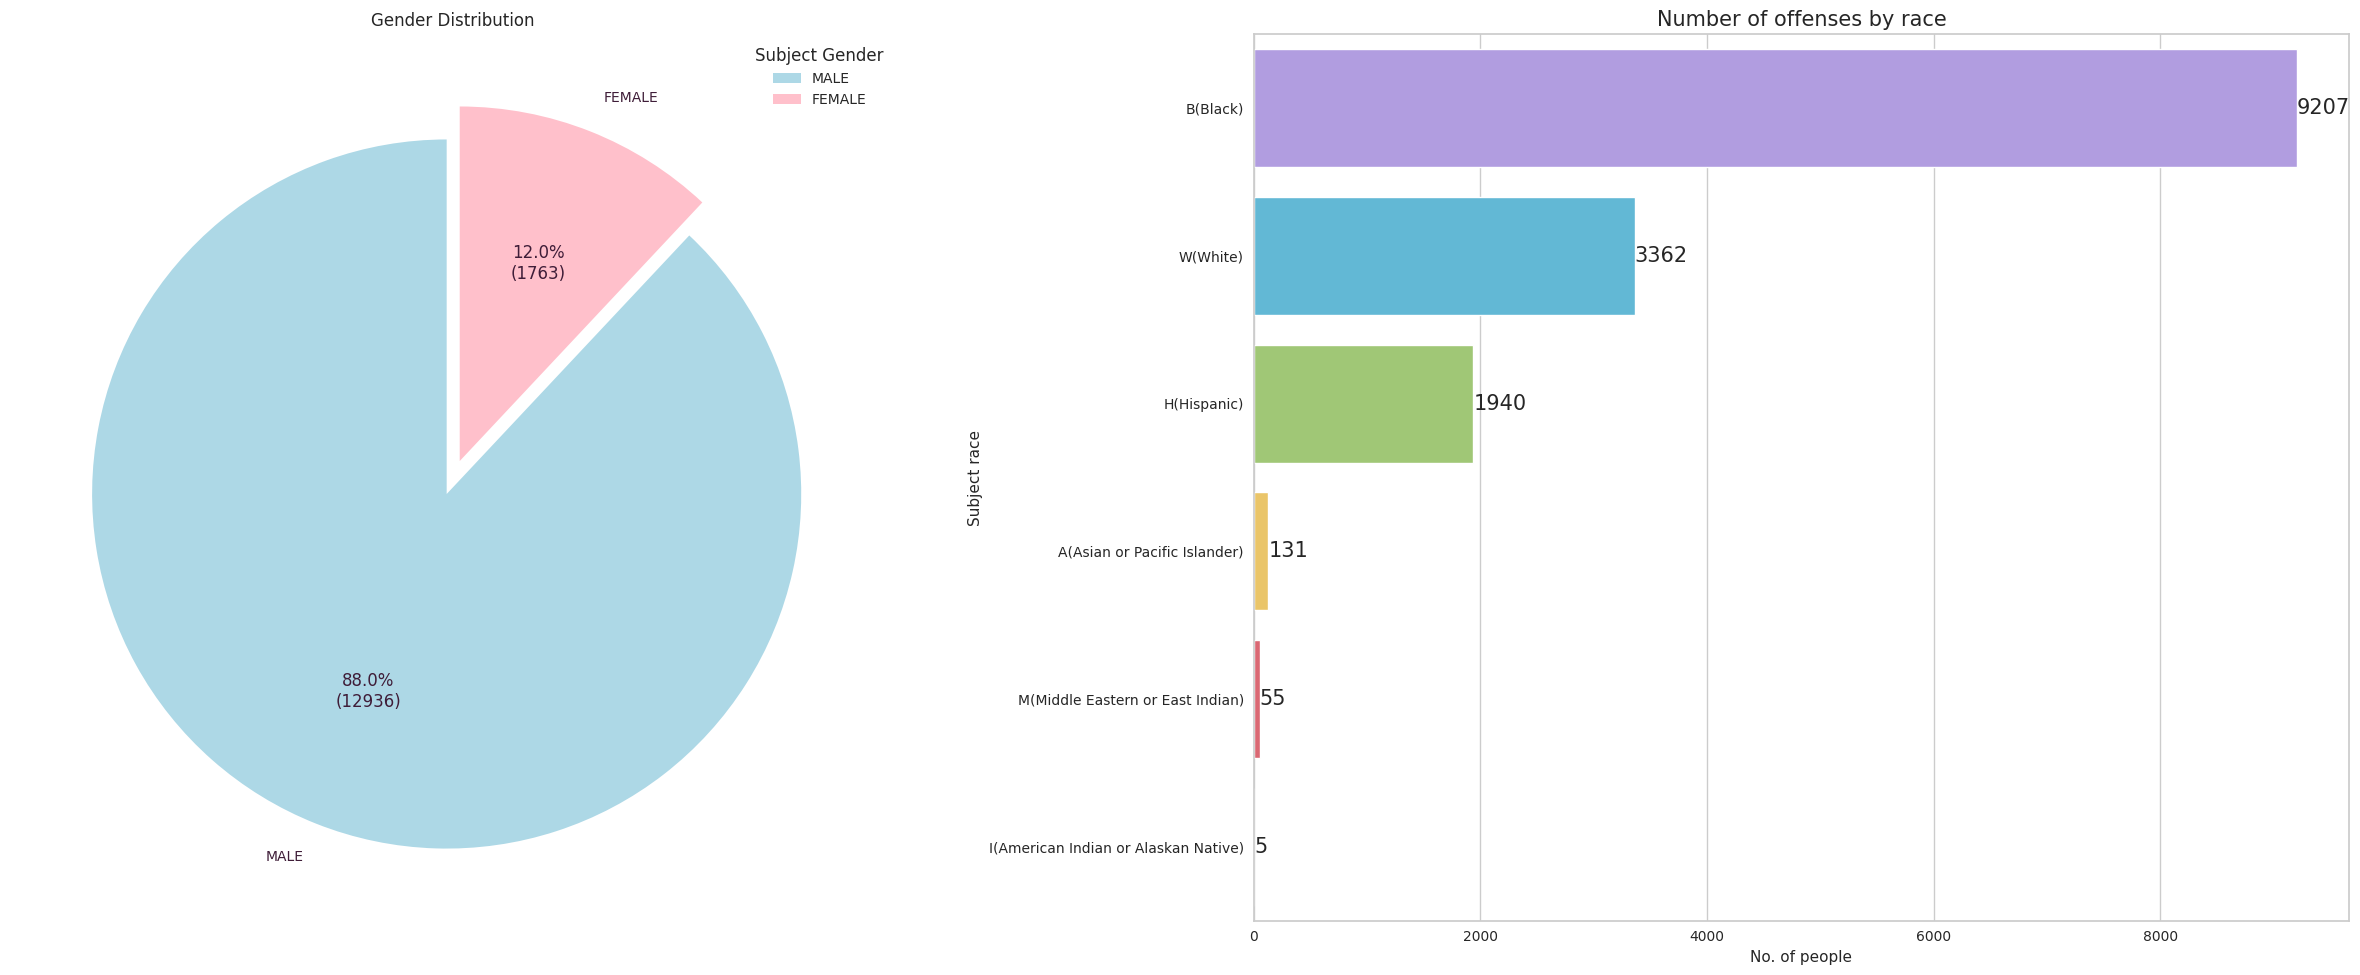

In [37]:
data = [len(df[df['SUBJECT_GENDER'] == feature]) for feature in df['SUBJECT_GENDER'].value_counts().index[0:2]]
labels = ['MALE', 'FEMALE']

colors = ['lightblue', 'pink']
explode = (0.05, 0.05)

# Creating autocpt arguments
def func(pct, allvalues):
    absolute = int(pct / 100. * np.sum(allvalues))
    return "{:.1f}%\n({:d})".format(pct, absolute)

# Creating the pie chart
plt.figure(figsize=(25, 10))
plt.subplot(1, 2, 1)
plt.pie(data, labels=labels, explode=explode, colors=colors, 
        autopct=lambda pct: func(pct, data), startangle=90, textprops=dict(color="#3F1D38"))

plt.legend(labels, title="Subject Gender")
plt.title("Gender Distribution")

# Creating the bar chart
plt.subplot(1, 2, 2)
order = df['SUBJECT_RACE'].value_counts().index
colors = ['#AC92EB', '#4FC1E8', '#A0D568', '#FFCE54', '#ED5564', '#9E9FA5']

# Set the font size for titles
sns.set(font_scale=1.25)

ax = sns.countplot(data=df, y='SUBJECT_RACE', order=order, palette=colors) 

for label in ax.containers:
    ax.bar_label(label)

plt.title('Number of offenses by race')
plt.ylabel('Subject race')
plt.xlabel('No. of people')

# Show plots
plt.tight_layout()
plt.show()

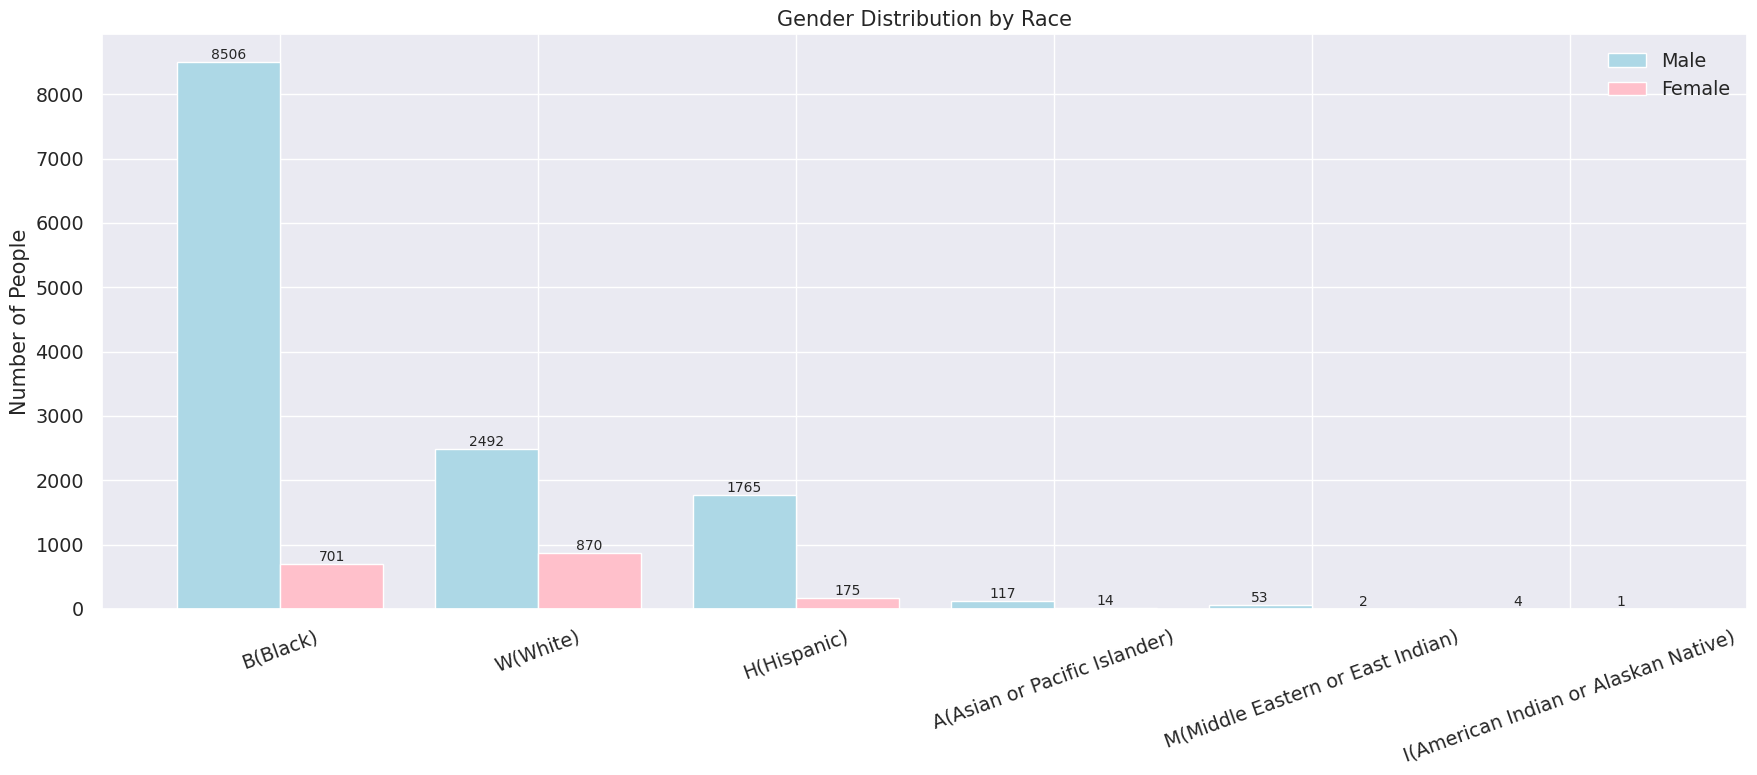

In [38]:
# Set the figure size
plt.figure(figsize=(18, 8))

# Extract the unique race categories to plot
race_to_plot = df['SUBJECT_RACE'].value_counts().index

# Filter data for male and female subjects
male = df[df['SUBJECT_GENDER'] == 'MALE']
female = df[df['SUBJECT_GENDER'] == 'FEMALE']

# Count the occurrences of gender and race combinations for male and female
male_counts = male['SUBJECT_RACE'].value_counts().reindex(race_to_plot, fill_value=0)
female_counts = female['SUBJECT_RACE'].value_counts().reindex(race_to_plot, fill_value=0)

# Set up positions for the bars
x = np.arange(len(race_to_plot))
width = 0.4  # Width of the bars
colors = ['lightblue', 'pink']  # Colors for male and female bars

# Create the bar plots
plt.bar(x - width/2, male_counts, width, color=colors[0], label='Male')
plt.bar(x + width/2, female_counts, width, color=colors[1], label='Female')

# Annotate the bars with their values
for i in range(len(race_to_plot)):
    plt.text(x[i] - width/2, male_counts[i], str(male_counts[i]), ha='center', va='bottom', fontsize=10)
    plt.text(x[i] + width/2, female_counts[i], str(female_counts[i]), ha='center', va='bottom', fontsize=10)

# Set the x-axis labels and tick rotation
plt.xticks(x, race_to_plot, rotation=20)

# Set labels, legend, and title
plt.ylabel("Number of People")
plt.legend()
plt.title("Gender Distribution by Race")

# Display the plot
plt.tight_layout()
plt.show()

### Number of offences distrubuted by Years and Months

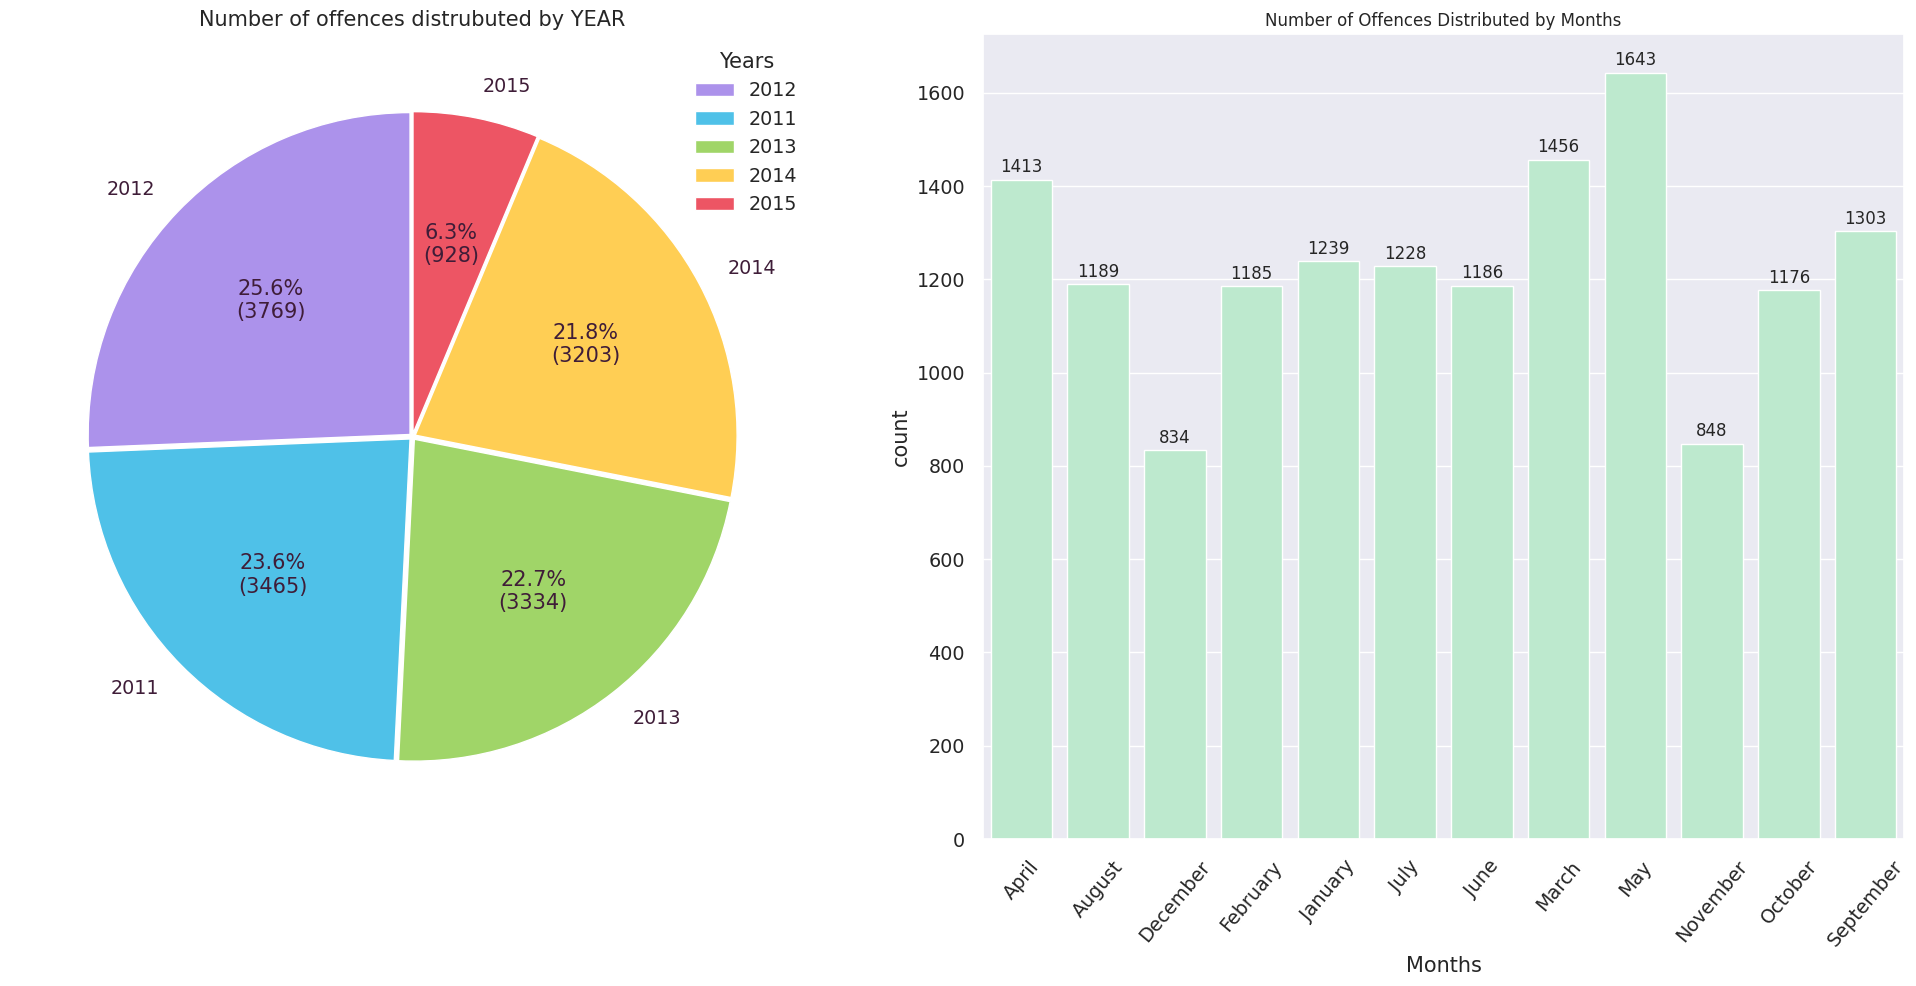

In [39]:
# Pie Chart

# Creating data
data = [len(df[df['INCIDENT_YEAR'] == feature]) for feature in df['INCIDENT_YEAR'].value_counts().index]
labels = df['INCIDENT_YEAR'].value_counts().index

colors = ['#AC92EB', '#4FC1E8', '#A0D568', '#FFCE54', '#ED5564'] # creating color parameters
explode = (0.01, 0.01, 0.01, 0.01, 0.01) # creating explode data

# Creating autocpt arguments
def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%\n({:d})".format(pct, absolute)

# Creating plot
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.pie(data, labels=labels, explode=explode, colors=colors, autopct=lambda pct: func(pct, data), 
        startangle=90, textprops=dict(color ="#3F1D38"))

# Adding legend
plt.legend(labels, title ="Years", loc ='best',)

plt.title("Number of offences distrubuted by YEAR")

# Bat chart
plt.subplot(1, 2, 2)
order = df['INCIDENT_MONTH'].value_counts().sort_index().index

# Set the font size for titles
sns.set(font_scale=1)

ax = sns.countplot(data=df, x='INCIDENT_MONTH', order=order, color='#B5F1CC') 
plt.xticks(rotation=50)

for label in ax.containers[0]:
    ax.annotate(format(int(label.get_height())), 
                (label.get_x() + label.get_width() / 2., label.get_height()), 
                ha='center', va='center', xytext=(0, 9), textcoords='offset points')
    
plt.title('Number of Offences Distributed by Months')
plt.xlabel('Months')

plt.tight_layout() 
plt.show()

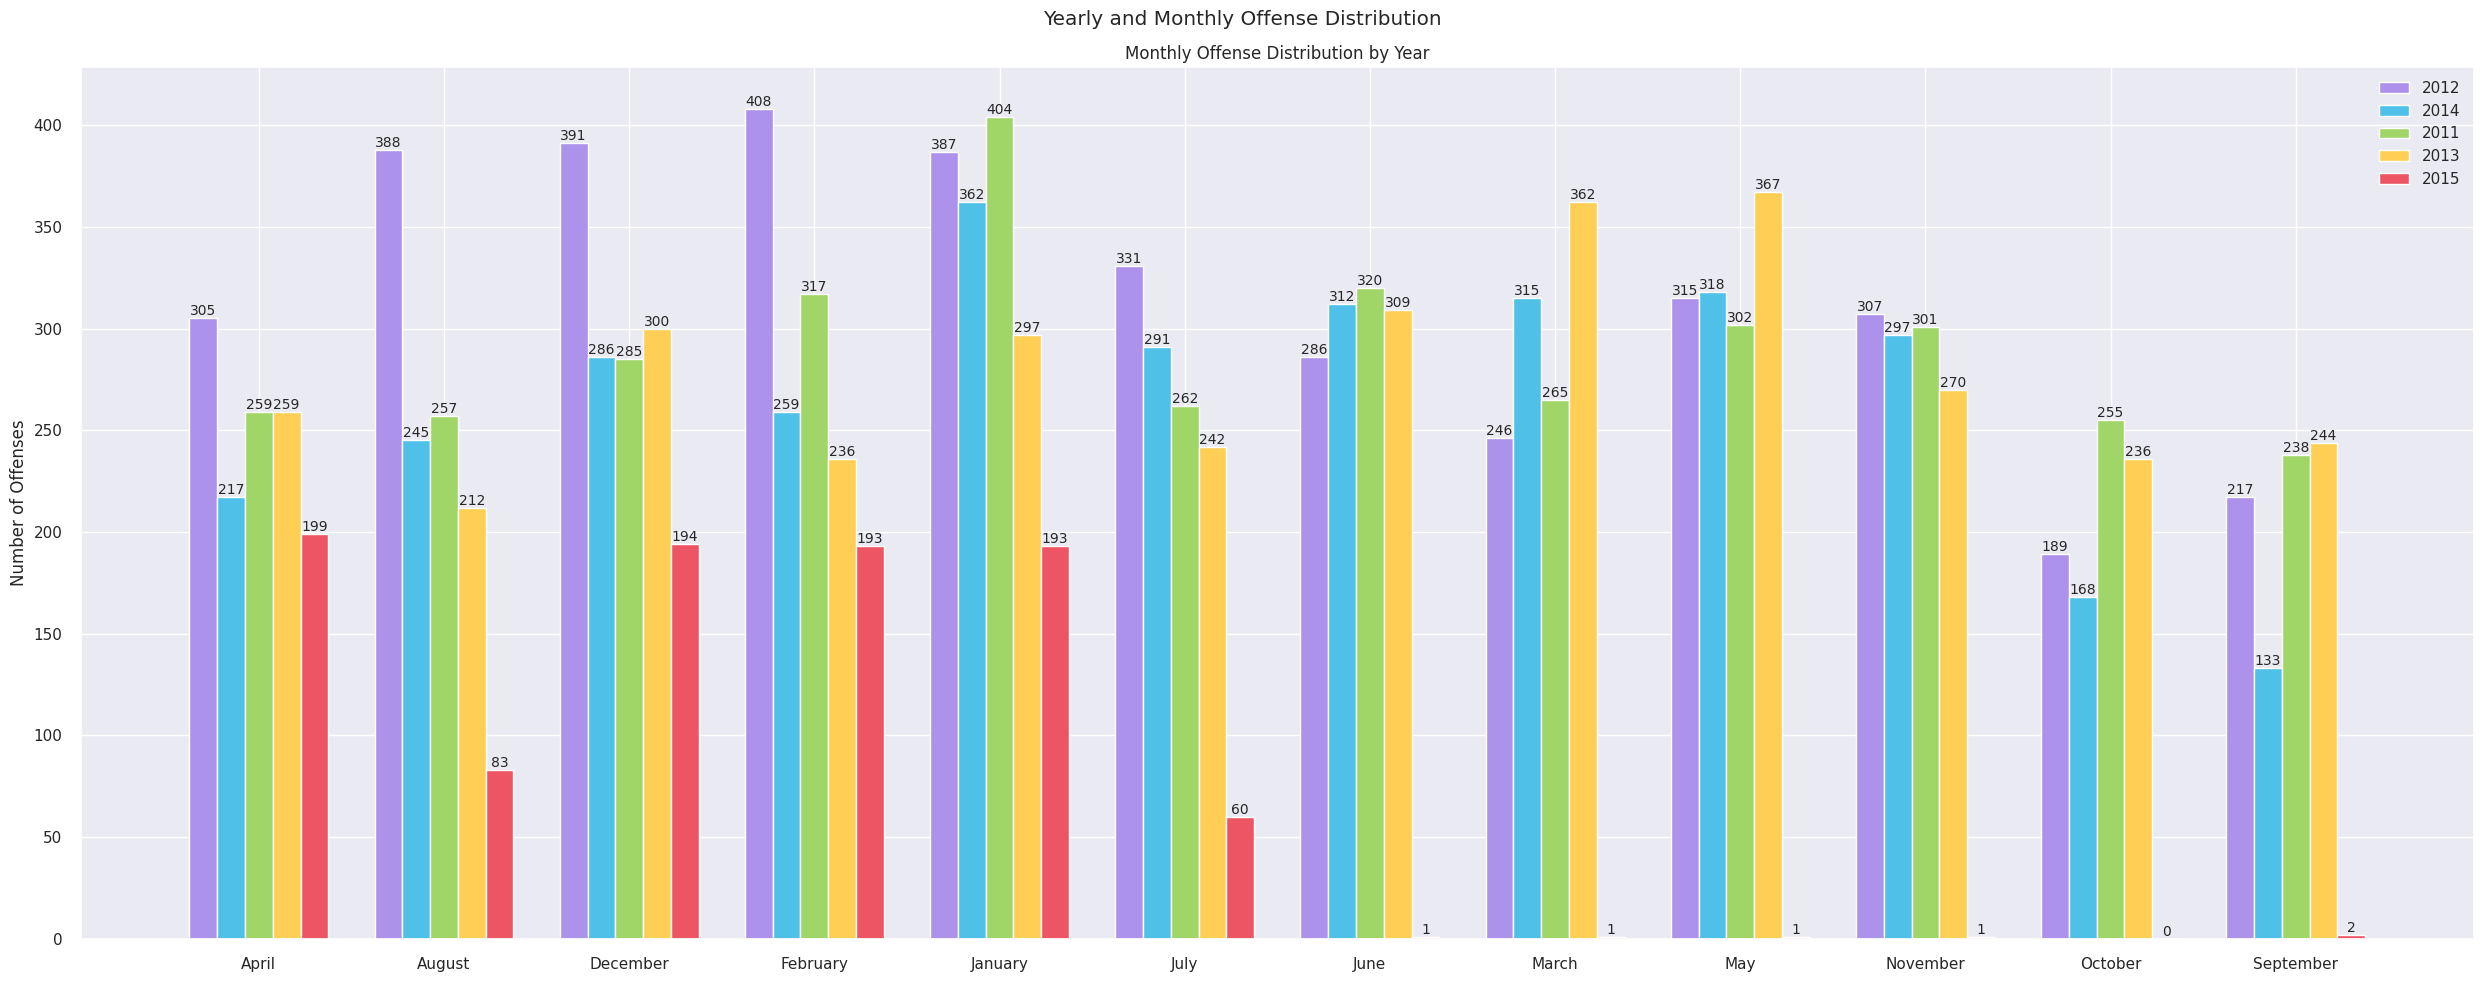

In [40]:
# Get unique years in your data
years_to_plot = df['INCIDENT_YEAR'].unique()

# Create a mapping from month names to their numeric values
month_name_to_number = {
    'January': 1,
    'February': 2,
    'March': 3,
    'April': 4,
    'May': 5,
    'June': 6,
    'July': 7,
    'August': 8,
    'September': 9,
    'October': 10,
    'November': 11,
    'December': 12
}

# An empty list to store monthly counts for each year
values = []

for year in years_to_plot:
    c = df[df['INCIDENT_YEAR'] == year]
    value = c['INCIDENT_MONTH'].map(month_name_to_number)  # Map month names to numbers
    value_counts = value.value_counts().sort_index()

    # Create an empty list to store the counts for all 12 months
    monthly_counts = [0] * 12
    
    # Fill in the counts for the months that exist
    for month, count in value_counts.items():
        monthly_counts[month - 1] = count  # Subtract 1 to adjust for zero-based indexing

    values.append(monthly_counts)

x = np.arange(1, 13)
width = 0.15
colors = ['#AC92EB', '#4FC1E8', '#A0D568', '#FFCE54', '#ED5564']

plt.figure(figsize=(25, 10))
for n in range(len(years_to_plot)):
    plt.bar(x + (n - 2) * width, values[n], width=width, color=colors[n])

# Annotate the bars with their values
for n in range(len(years_to_plot)):
    for i in range(12):
        plt.text(x[i] + (n - 2) * width, values[n][i], str(values[n][i]), ha='center', va='bottom', fontsize=10)

order = df['INCIDENT_MONTH'].value_counts().sort_index().index
plt.xticks(x, order)
plt.ylabel("Number of Offenses")
plt.legend(years_to_plot)  # Use the extracted unique years
plt.title("Monthly Offense Distribution by Year")

# Adding an overall title to the entire figure
plt.suptitle("Yearly and Monthly Offense Distribution")

# Show plots
plt.tight_layout()
plt.show()

### Number of Offences Distributed by Location

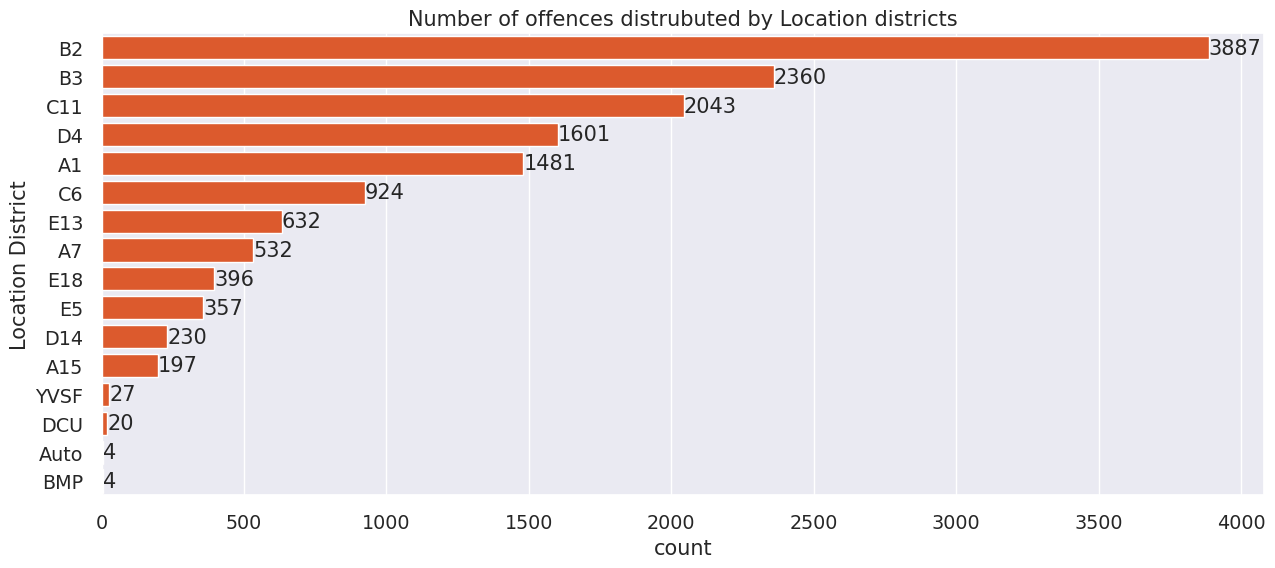

In [41]:
# Bar chart 1: Location district
plt.figure(figsize=(15, 6))
order = df['LOCATION_DISTRICT'].value_counts().index[0:16]

# Set the font size for titles
sns.set(font_scale=1.25)

ax = sns.countplot(y=df['LOCATION_DISTRICT'], order=order, color='#F94C10')

for label in ax.containers:
    ax.bar_label(label)

plt.title('Number of offences distrubuted by Location districts')
plt.ylabel('Location District')

plt.show()

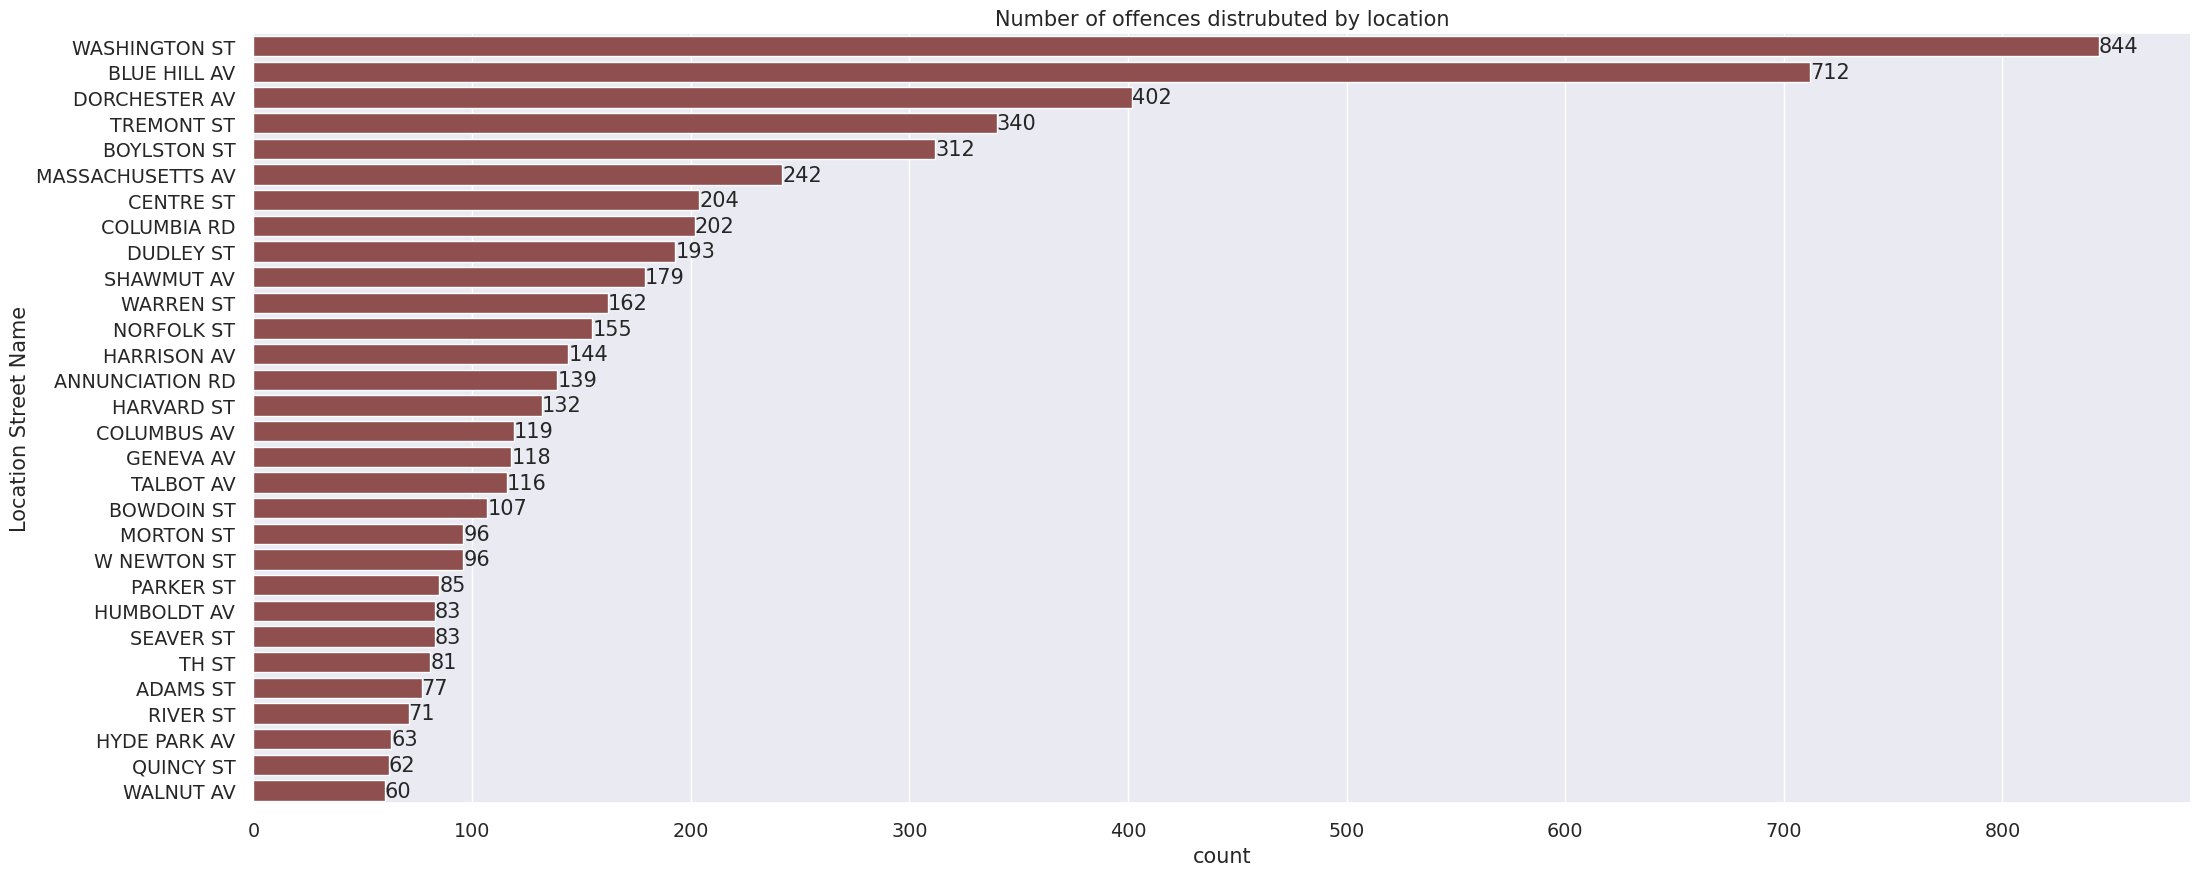

In [42]:
# Bar chart: Location
plt.figure(figsize=(25, 10))
order = df['LOCATION_STREET_ADDRESS'].value_counts().index[0:30]

# Set the font size for titles
sns.set(font_scale=1.25)

ax = sns.countplot(y=df['LOCATION_STREET_ADDRESS'], order=order, color='#9A4444')

for label in ax.containers:
    ax.bar_label(label)

plt.title('Number of offences distrubuted by location')
plt.ylabel('Location Street Name')

plt.show()

### Officer Related Information

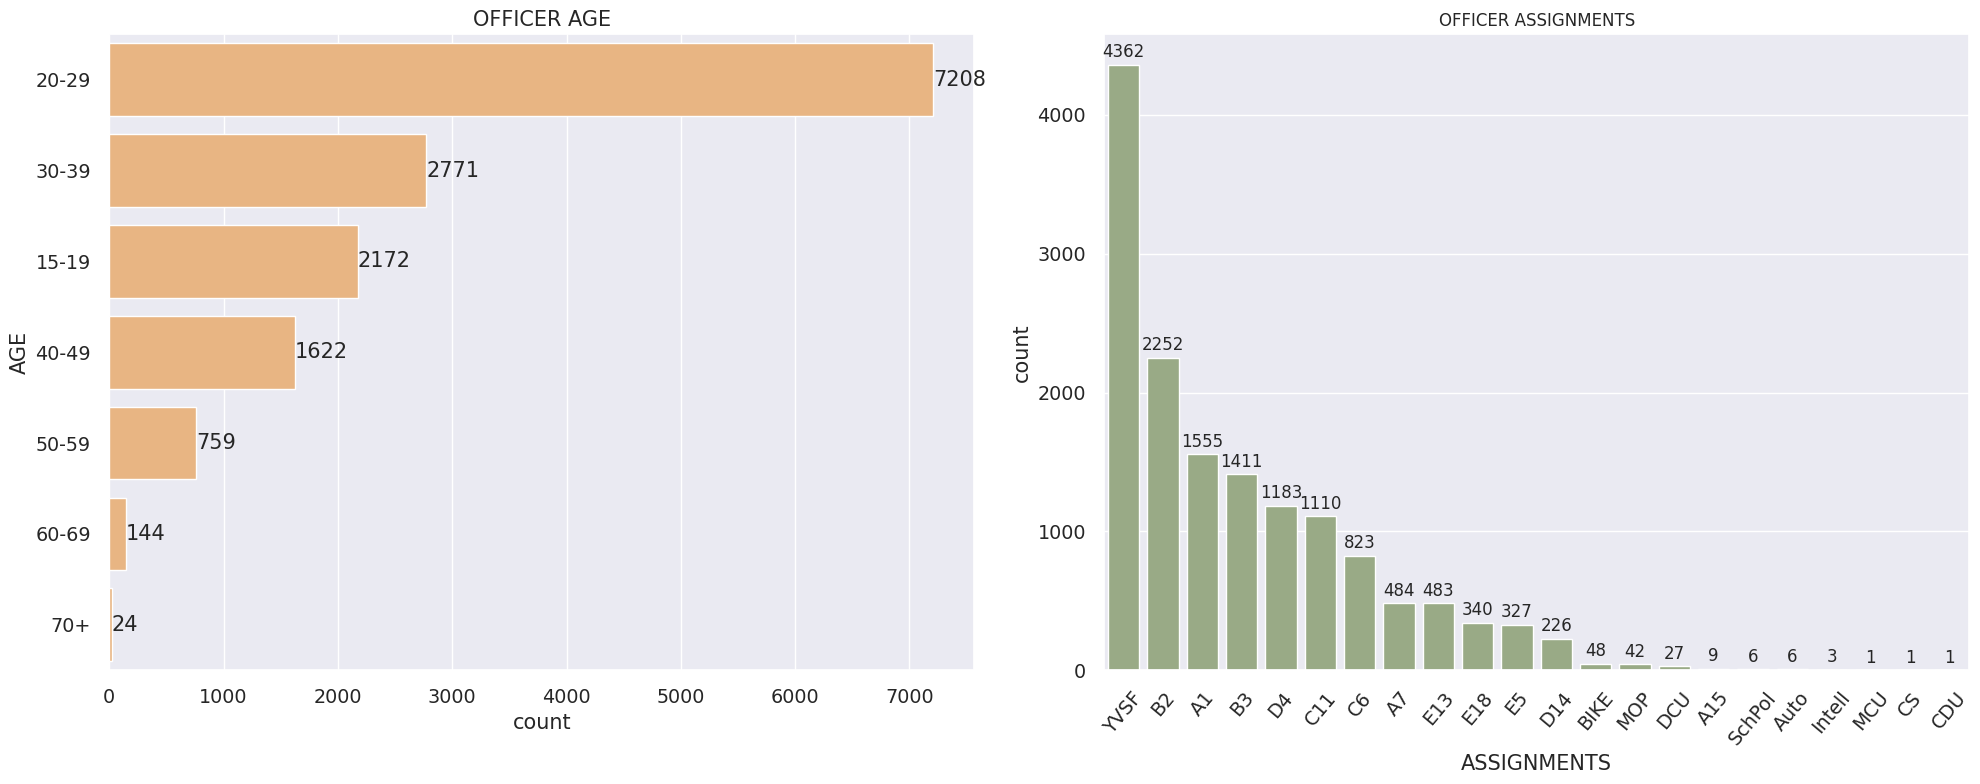

In [43]:
# Creating data
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
order = df['OFFICER_AGE'].value_counts().index[:12]
ax = sns.countplot(y=df['OFFICER_AGE'], order=order, color='#F9B572')

for label in ax.containers:
    ax.bar_label(label)

plt.ylabel('AGE')
plt.title("OFFICER AGE")

# Bat chart
plt.subplot(1, 2, 2)
order = df['OFFICER_ASSIGNMENT.1'].value_counts().index

# Set the font size for titles
sns.set(font_scale=1)

ax = sns.countplot(data=df, x='OFFICER_ASSIGNMENT.1', order=order, color='#99B080') 
plt.xticks(rotation=50)

for label in ax.containers[0]:
    ax.annotate(format(int(label.get_height())), 
                (label.get_x() + label.get_width() / 2., label.get_height()), 
                ha='center', va='center', xytext=(0, 9), textcoords='offset points')
    
plt.title('OFFICER ASSIGNMENTS')
plt.xlabel('ASSIGNMENTS')

plt.tight_layout() 
plt.show()

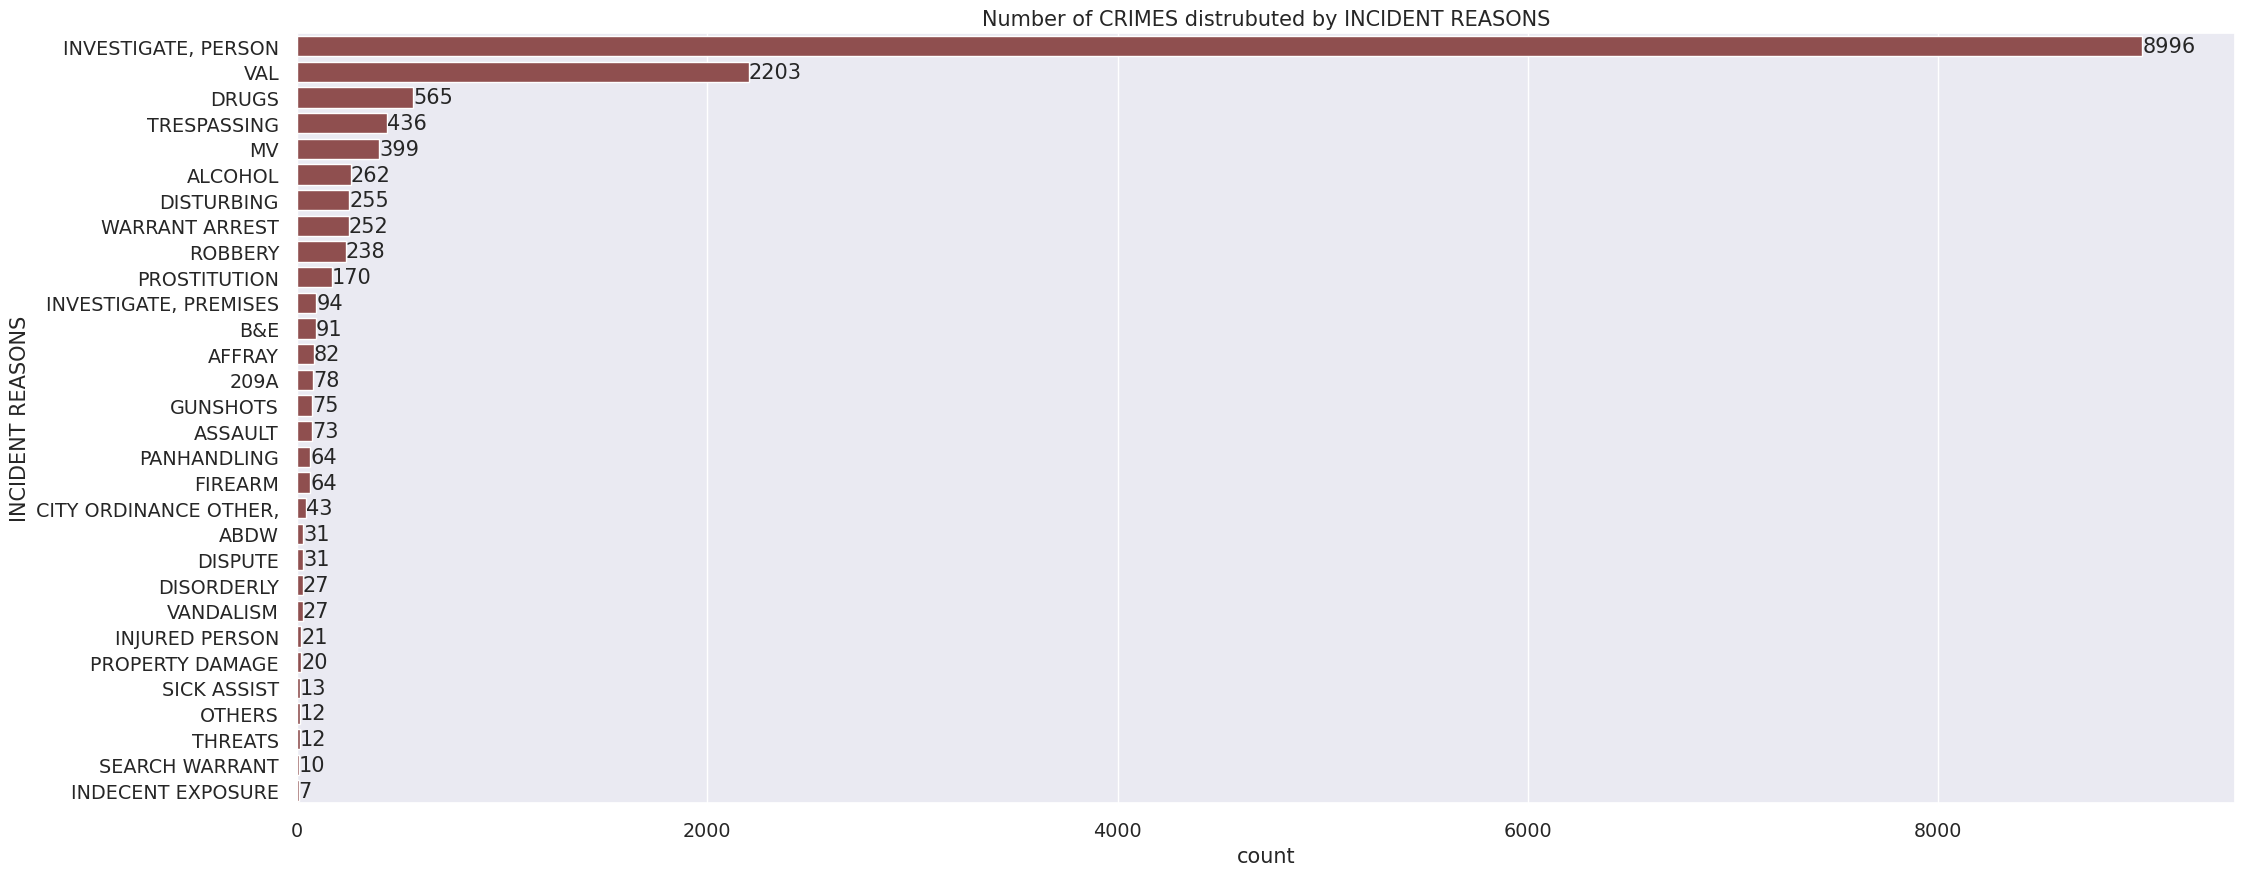

In [44]:
# Bar chart 1: Location
plt.figure(figsize=(25, 10))
order = df['INCIDENT_REASON.1'].value_counts().index[0:30]

# Set the font size for titles
sns.set(font_scale=1.25)

ax = sns.countplot(y=df['INCIDENT_REASON.1'], order=order, color='#9A4444')

for label in ax.containers:
    ax.bar_label(label)

plt.title('Number of CRIMES distrubuted by INCIDENT REASONS')
plt.ylabel('INCIDENT REASONS')

plt.show()

# Step 3: Dimensionality Reduction

In [45]:
# 81% percent
mca = MCA(n_components=1500, n_iter=50, copy=True, check_input=True, random_state=42, one_hot=True)
mca_results = mca.fit(encoded_df)

In [46]:
mca_results.eigenvalues_summary

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,0.319,0.19%,0.19%
1,0.271,0.16%,0.35%
2,0.262,0.15%,0.50%
3,0.257,0.15%,0.66%
4,0.253,0.15%,0.81%
...,...,...,...
1495,0.091,0.05%,83.20%
1496,0.091,0.05%,83.25%
1497,0.091,0.05%,83.31%


In [47]:
features = mca_results.column_contributions_.sum(axis=1)[:1500].keys()

selected_features = []

for feature in features:
    for i in range(len(df.columns)):
        if df.columns[i] in feature:
            selected_features.append(df.columns[i])
            
selected_features = list(set(selected_features))
selected_features

['SUBJECT_DETAILS.2',
 'INCIDENT_YEAR',
 'LOCATION_DISTRICT',
 'SUBJECT_DETAILS',
 'SUBJECT_RACE',
 'LOCATION_STREET_ADDRESS',
 'INCIDENT_MONTH',
 'SUBJECT_GENDER',
 'INCIDENT_REASON.1',
 'OFFICER_AGE',
 'OFFICER_ASSIGNMENT.1']

In [48]:
# Scaling
scale = StandardScaler()
scaled_data = scale.fit_transform(encoded_df[selected_features])
reduced_df = pd.DataFrame(scaled_data, columns=selected_features)

reduced_df.head()

,SUBJECT_DETAILS.2,INCIDENT_YEAR,LOCATION_DISTRICT,SUBJECT_DETAILS,SUBJECT_RACE,LOCATION_STREET_ADDRESS,INCIDENT_MONTH,SUBJECT_GENDER,INCIDENT_REASON.1,OFFICER_AGE,OFFICER_ASSIGNMENT.1
0,0.691232,-0.499446,-0.592462,0.356550,1.784510,-0.694692,-1.031008,0.369156,-1.265050,0.484601,-0.878908
1,0.691232,-0.499446,-0.360242,0.356550,-0.634997,-0.915430,0.708208,0.369156,-0.260494,-0.418955,-0.749235
2,-1.613920,1.121452,-1.289123,-2.804658,-0.634997,1.397678,1.287947,0.369156,-0.260494,-1.322510,1.325529
3,0.691232,-1.309895,-0.592462,0.356550,-0.030120,-0.282896,0.418339,0.369156,-0.260494,-1.322510,1.325529
4,0.691232,1.121452,0.568640,0.356550,-0.634997,0.097367,0.998077,0.369156,-1.265050,-1.322510,1.325529


# Step 4: Clustering

### Choosing the Number of clusters k

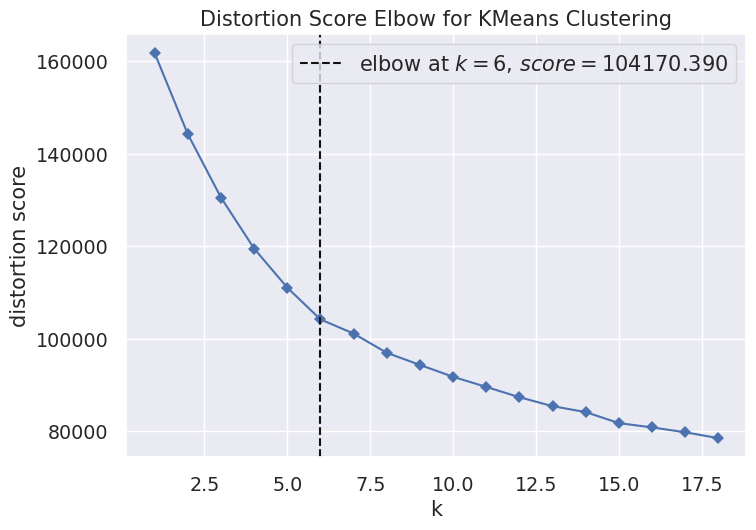

In [49]:
# Elbow Method to find optimal k
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1, 19), timings=False)
visualizer.fit(scaled_data)
visualizer.show()

# Get optimal k from the Elbow method
optimal_k = visualizer.elbow_value_

In [50]:
optimal_k

6

### K-means clustering

In [51]:
kmeans = KMeans(n_clusters=optimal_k, random_state=42, max_iter=100).fit(scaled_data)
 
# extract centroids of clusters into a dataframe
centers = kmeans.cluster_centers_

# extract cluster labels
labels = kmeans.labels_ 

# Step 5: Cluster Analysis

### Analyzing clusters characteristics

In [52]:
cluster_characteristics = []
size_of_clusters = []

for i in range(optimal_k):    
    cluster_data = scaled_data[labels == i]
    cluster_size = len(cluster_data)    
    cluster_center = centers[i]
    avg_distance = np.mean(np.linalg.norm(cluster_data - cluster_center, axis=1))    
    cluster_characteristics.append({
        "Cluster": i,        
        "Size": cluster_size,
        "Avg Distance": avg_distance,    
    })
    
cluster_characteristics

[{'Cluster': 0, 'Size': 2191, 'Avg Distance': 2.694259821050004},
 {'Cluster': 1, 'Size': 3728, 'Avg Distance': 2.347486732437477},
 {'Cluster': 2, 'Size': 1453, 'Avg Distance': 2.90719634459388},
 {'Cluster': 3, 'Size': 1628, 'Avg Distance': 3.1279589102199217},
 {'Cluster': 4, 'Size': 3126, 'Avg Distance': 2.3085402770803825},
 {'Cluster': 5, 'Size': 2574, 'Avg Distance': 2.6195923840375315}]

In [53]:
# Print the cluster centroids
print("Cluster Centroids:")
print(centers)

Cluster Centroids:
[[ 2.72495941e-01 -6.55543879e-02 -7.23774852e-02  3.46450070e-01
   1.76849782e+00  2.57065010e-02  5.98500009e-06  3.69155520e-01
  -1.38178176e-01  5.03158539e-01 -5.11018464e-01]
 [ 5.57877634e-01  1.20999547e-01  3.41091163e-01  3.56549774e-01
  -4.86860811e-01  5.36567525e-02  3.34531147e-02  3.69155520e-01
   3.44480373e-02 -2.71593740e-01  1.07700142e+00]
 [ 1.15340564e-01 -2.86828622e-02  4.29874492e-02  3.10861300e-01
   6.83825752e-01 -6.22166986e-02  5.16628986e-02 -2.70888540e+00
   3.32605022e-02  2.61976660e-01 -3.62715741e-01]
 [ 3.32913658e-02 -7.23175419e-02  1.67103902e-01 -2.80465751e+00
   8.39442131e-02 -5.74283369e-02 -4.45976441e-02 -1.84816218e-01
  -2.07357333e-02 -4.56140367e-01 -3.21319926e-02]
 [ 5.44486713e-01 -4.98879923e-02 -5.00420755e-01  3.56549774e-01
  -5.20059015e-01 -4.57074123e-02 -4.02965908e-02  3.69155520e-01
   3.67598756e-02  9.00540022e-02 -8.49082458e-01]
 [-1.78735823e+00  3.07007455e-03  4.53770694e-02  3.54093513e-01


### Silhouette Score, Davies-Bouldin Index, Variance Ratio Criterion, Within-Cluster Sum of Squares (WCSS)

In [54]:
silhouette_avg = silhouette_score(scaled_data, kmeans.labels_)
print('Silhouette Score:', round(silhouette_avg, 4))

db_index = davies_bouldin_score(scaled_data, kmeans.labels_)
print('Davies-Bouldin Index:', round(db_index, 4))

ch_score = calinski_harabasz_score(scaled_data, kmeans.labels_)
print('Calinski-Harabasz Index (Variance Ratio Criterion):', round(ch_score, 4))

wcss = kmeans.inertia_
print('Within-Cluster Sum of Squares (WCSS):', round(wcss, 4))

Silhouette Score: 0.1322
Davies-Bouldin Index: 1.937
Calinski-Harabasz Index (Variance Ratio Criterion): 1622.9949
Within-Cluster Sum of Squares (WCSS): 104170.3903


### Cluster Visualization

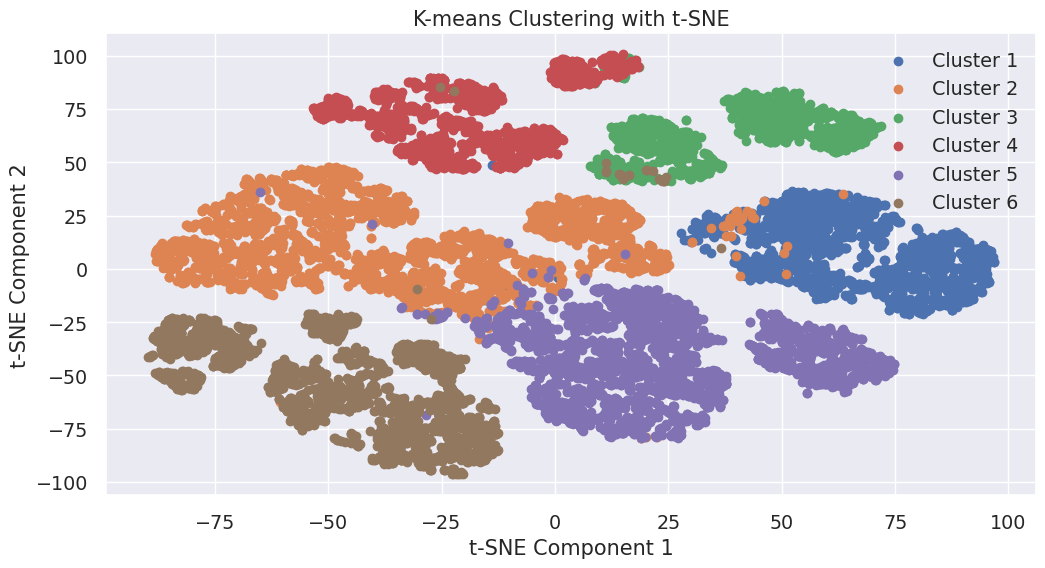

In [55]:
# Visualization of kmeans with TSNE

tsne = TSNE(n_components=2, random_state=0)
tsne_results = tsne.fit_transform(scaled_data)

plt.figure(figsize=(12, 6))
for i in range(optimal_k):
    plt.scatter(tsne_results[labels == i][:, 0], 
                tsne_results[labels == i][:, 1], label=f'Cluster {i + 1}')
    
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('K-means Clustering with t-SNE')
plt.legend(loc ='best')
plt.show()

In [56]:
df['CLUSTERS'] = kmeans.labels_

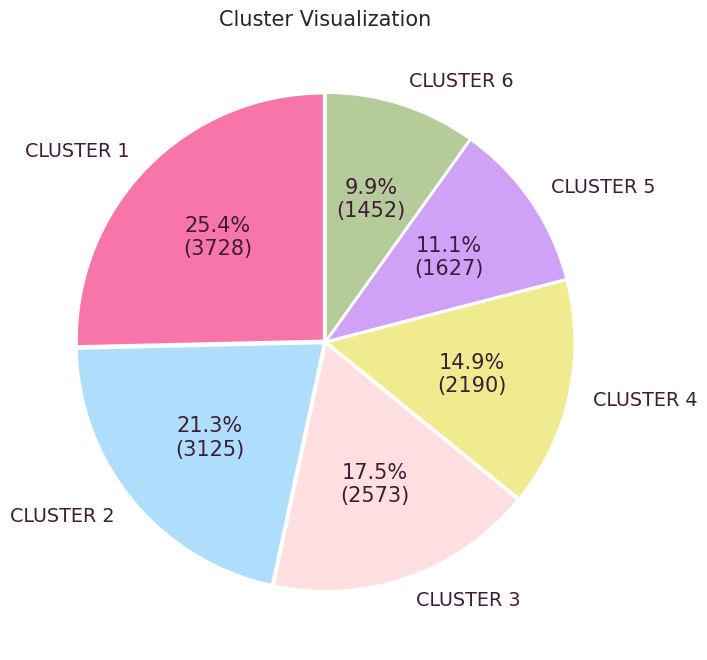

In [57]:
data = [len(df[df['CLUSTERS'] == feature]) for feature in df['CLUSTERS'].value_counts().index]
labels = ['CLUSTER 1', 'CLUSTER 2', 'CLUSTER 3', 'CLUSTER 4', 'CLUSTER 5', 'CLUSTER 6']

colors = ['#F875AA', '#AEDEFC', '#FFDFDF', '#F1EB90', '#D0A2F7', '#B5CB99']
explode = (0.01, 0.01, 0.01, 0.01, 0.01, 0.01)


# Creating autocpt arguments
def func(pct, allvalues):
    absolute = int(pct / 100. * np.sum(allvalues))
    return "{:.1f}%\n({:d})".format(pct, absolute)

# Creating the pie chart
plt.figure(figsize=(15, 8))
plt.pie(data, labels=labels, explode=explode, colors=colors, 
        autopct=lambda pct: func(pct, data), startangle=90, textprops=dict(color="#3F1D38"))

plt.title('Cluster Visualization')
plt.show()

In [58]:
def cluster_profile(df):
    profiles = {}
    
    for column in df.columns:
        if column != 'CLUSTERS':
            profiles[column] = df[column].mode()[0]
    
    return profiles

In [59]:
cluster_profile = df.groupby('CLUSTERS').apply(cluster_profile)
cluster_profile_df = pd.DataFrame(cluster_profile.tolist(), index=cluster_profile.index)

cluster_profile_df

,SUBJECT_GENDER,LOCATION_DISTRICT,SUBJECT_DETAILS,SUBJECT_RACE,SUBJECT_DETAILS.2,INCIDENT_REASON.1,OFFICER_ASSIGNMENT.1,OFFICER_AGE,INCIDENT_YEAR,INCIDENT_MONTH,LOCATION_STREET_ADDRESS
CLUSTERS,,,,,,,,,,,
0,MALE,A1,YES,W(White),Light,"INVESTIGATE, PERSON",A1,20-29,2012,May,WASHINGTON ST
1,MALE,B2,YES,B(Black),Med,"INVESTIGATE, PERSON",YVSF,20-29,2014,May,WASHINGTON ST
2,FEMALE,B2,YES,W(White),Med,"INVESTIGATE, PERSON",B2,20-29,2012,May,DORCHESTER AV
3,MALE,B2,NO,B(Black),Med,"INVESTIGATE, PERSON",YVSF,20-29,2012,May,WASHINGTON ST
4,MALE,B2,YES,B(Black),Med,"INVESTIGATE, PERSON",B2,20-29,2012,April,BLUE HILL AV
5,MALE,B2,YES,B(Black),Dark,"INVESTIGATE, PERSON",YVSF,20-29,2011,May,WASHINGTON ST
